In [1]:
import pandas as pd
import gensim
import numpy as np
from sklearn.model_selection import KFold
import nltk
from nltk.corpus import stopwords
# Import textblob
from textblob import Word, TextBlob
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
import warnings
warnings.filterwarnings("ignore")

# Plant protein

## Data Preprocessing

In [2]:
df = pd.read_excel('Meals_w_Goals_deid_snapshot.xlsx', 'choose_plant_proteins')

In [3]:
df['meal_ingredients'].isnull().sum()

0

In [4]:
df = df.dropna(axis=0, subset=['meal_ingredients'])

In [5]:
df['meal_ingredients'].isnull().sum()

0

In [6]:
df['meal_ingredients'] = df['meal_ingredients'].astype(str)

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yashjain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yashjain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
def preprocess_meals(meal):
    processed_meal = meal
    processed_meal.replace('[^\w\s]', '') #replaces all non alphabets with blank spaces
    processed_meal = " ".join(word for word in processed_meal.split() if word not in stop_words) #removing stopwords
    processed_meal = " ".join(Word(word).lemmatize() for word in processed_meal.split()) #lemmatizing the words
    return(processed_meal)

In [9]:
from sklearn.preprocessing import OrdinalEncoder
label = df['expert_assessment'] #creating labels
enc = OrdinalEncoder(categories = [['not_really', 'yes']])
df['expert_assessment'] = enc.fit_transform(label.to_numpy().reshape(-1,1))

In [10]:
#Total negative and positive samples
total = df['expert_assessment'].count()
negative = df['expert_assessment'][df['expert_assessment']==0].count()
positive = df['expert_assessment'][df['expert_assessment']==1].count()
print('Total observations:', total)
print('Total negative labels:', negative)
print('Total positive labels:', positive)

Total observations: 487
Total negative labels: 404
Total positive labels: 83


# TFIDF


## Meal Ingredients

In [11]:
df['meal_ingredients'] = df['meal_ingredients'].apply(lambda x: preprocess_meals(x))

In [12]:
df['meal_ingredients']

0                                                Pretzel
1                                    Turkey burger salad
2                                       Quinoa vegetable
3                                          Chicken salad
4                                     Salad sweet potato
                             ...                        
482    Yellow rice chicken red beans. Mixed salad: sp...
483    Yellow rice, black bean beef meatballs. 16 oz ...
484    Hero size French bread, butter lightly smeared...
485                              Half cup oatmeal banana
486    Arrow com Gandules Dos Pasteles de platano car...
Name: meal_ingredients, Length: 487, dtype: object

In [13]:
#Creating a document for all the words
document = []
for i in df['meal_ingredients']:
    if i != '':
        document.append(i)

In [14]:
document

['Pretzel',
 'Turkey burger salad',
 'Quinoa vegetable',
 'Chicken salad',
 'Salad sweet potato',
 'Boiling egg',
 'Bagel egg',
 'Boiling egg coffee',
 'Pepper onion tomato onion omelette',
 'Lentil soup',
 'Cucumber, avocado, sweet yam diet Sunkist',
 'Green bean strawberry',
 'Avocado,tomatoes, onions,garlic',
 'Cream cheese ,substitute sugar,splenda',
 'Coffee,turkey,bread',
 'Cream cheese',
 'Viandas ,chicken ,ginger ale,',
 'Grapefruit cup',
 'Avocado,diet Ginger ale',
 'Milk',
 'Avocado , potato diet ginger ale',
 'Grapefruit',
 'Vegetables',
 'Milk fat free banana',
 'Grapefruit ,water',
 'Water grapefruit',
 'Avocado,cucumber',
 'Whole wheat toast turkey',
 'Avocado drink diet Sunkist',
 'Bread',
 'Diet soda',
 'Coffee',
 'Splenda coffee',
 'Chick pea , tomatoes, lettuce, avocado',
 'Salad,chicken,avocado lemonade',
 'Tuna, whole wheat bread, tea',
 'Steak,Season potato , Mac cheese water',
 'BBQ ribs, mashed potatoes, string bean macaroni salad. 16 oz glass carrot juice.',
 '2

In [15]:
data_X = np.squeeze(pd.DataFrame(df['meal_ingredients']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [16]:
#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [17]:
print(X_train.shape, X_test.shape)

(389,) (98,)


In [18]:
#Performing cross validation
train_accuracy = []
test_accuracy = []
for i in range(2000):
    data_X = np.squeeze(pd.DataFrame(df['meal_ingredients']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    lr.fit(train, y_train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

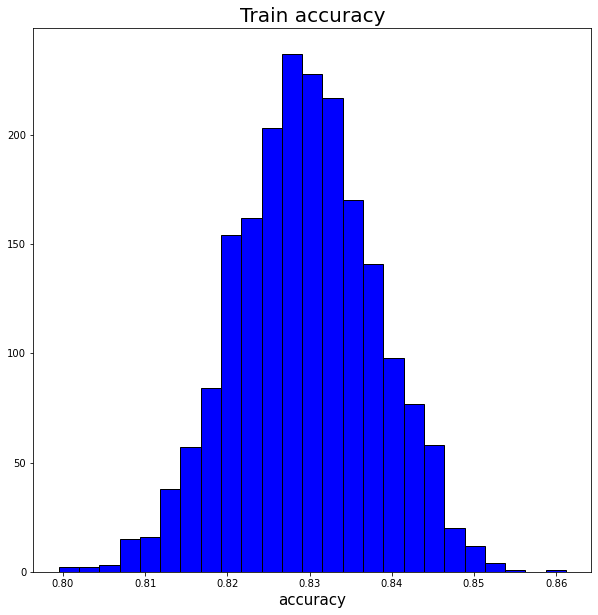

In [19]:
#Plotting the frequency distribution for training set
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
plt.show()

In [20]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.8294177377892031
0.008879658067556776


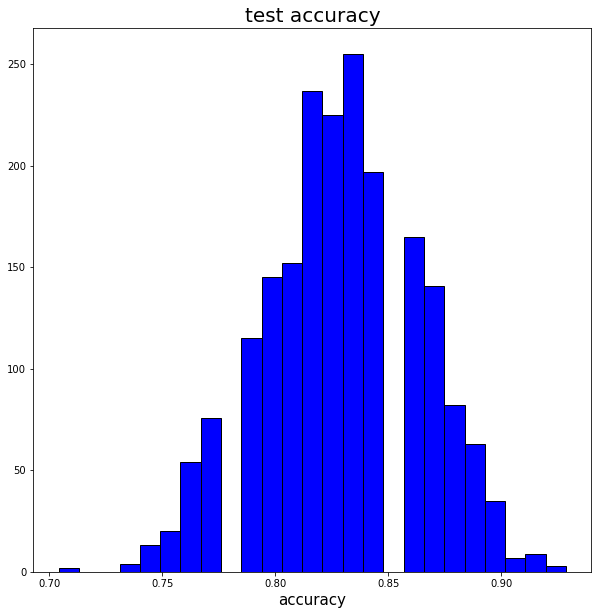

In [21]:
#Plotting the frequency distribution for test set
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [22]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.8288979591836735
0.03418318001471436


# TFIDF Meal Title

In [89]:
df['meal_title'].isnull().sum()

1

In [90]:
df['meal_title'] = df['meal_title'].astype(str)

In [91]:
df = df.dropna(axis=0, subset=['meal_title'])

In [92]:
df['meal_title'].isnull().sum()

0

In [93]:
document = []
for i in df['meal_title']:
    if i != '':
        document.append(i)

In [94]:
data_X = np.squeeze(pd.DataFrame(df['meal_title']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [95]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [96]:
print(X_train.shape, X_test.shape)

(755,) (189,)


In [97]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['meal_title']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=70, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

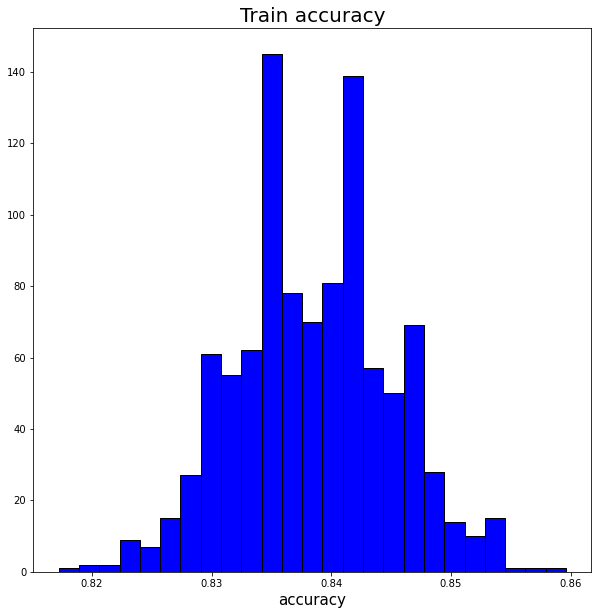

In [98]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [99]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.8385033112582782
0.006489403939718133


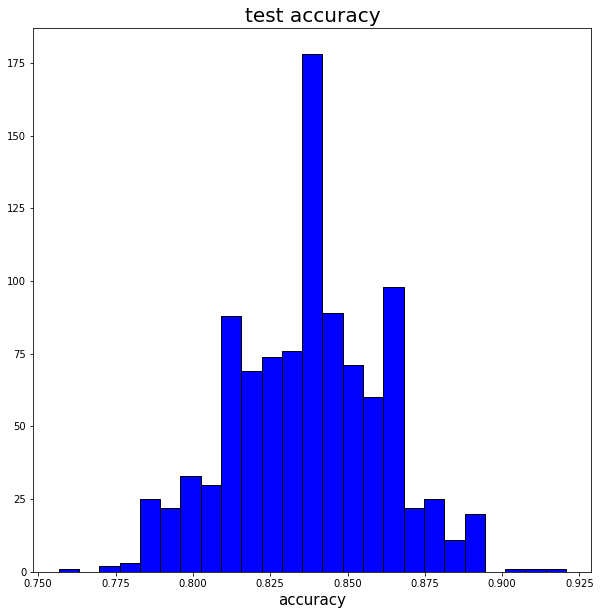

In [100]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [101]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.8372962962962963
0.024366787823068156


# TFIDF Ingredients + Title

In [23]:
df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str)

In [24]:
document = []
for i in df['ingredients_and_title']:
    if i != '':
        document.append(i)

In [25]:
document

['Pretzel Pretzel',
 'Turkey burger salad Salad with turkey burger',
 'Quinoa vegetable Quinoa and vegetables',
 'Chicken salad Chicken with mixed vegetables',
 'Salad sweet potato Salad ,sweet potatoes and avocado',
 'Boiling egg Boiling eggs with one cracker',
 'Bagel egg 1/2bagel with one egg',
 'Boiling egg coffee Coffee and egg',
 'Pepper onion tomato onion omelette Vegetables omelette',
 'Lentil soup Lentil soup',
 'Cucumber, avocado, sweet yam diet Sunkist Rice with gandules',
 'Green bean strawberry Alfredo fettuccine with oven chicken ,salad',
 'Avocado,tomatoes, onions,garlic Boil vegetables,like yam,sweet potatoes etc.',
 'Cream cheese ,substitute sugar,splenda Bread with coffee',
 'Coffee,turkey,bread Sandwich',
 'Cream cheese Coffee and bread',
 'Viandas ,chicken ,ginger ale, Sancocho',
 'Grapefruit cup Grapefruit',
 'Avocado,diet Ginger ale Rice with gandules ,roasted chicken , potatoes',
 'Milk Cornmeal',
 'Avocado , potato diet ginger ale Rice broccoli , chicken',
 'Gra

In [26]:
data_X = np.squeeze(pd.DataFrame(df['ingredients_and_title']))
data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)

In [28]:
print(X_train.shape, X_test.shape)

(389,) (98,)


In [29]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    data_X = np.squeeze(pd.DataFrame(df['ingredients_and_title']))
    data_y = np.squeeze(pd.DataFrame(df['expert_assessment']))
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
    tfidf = TfidfVectorizer(max_features=500, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
    train = tfidf.fit_transform(X_train)
    test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))


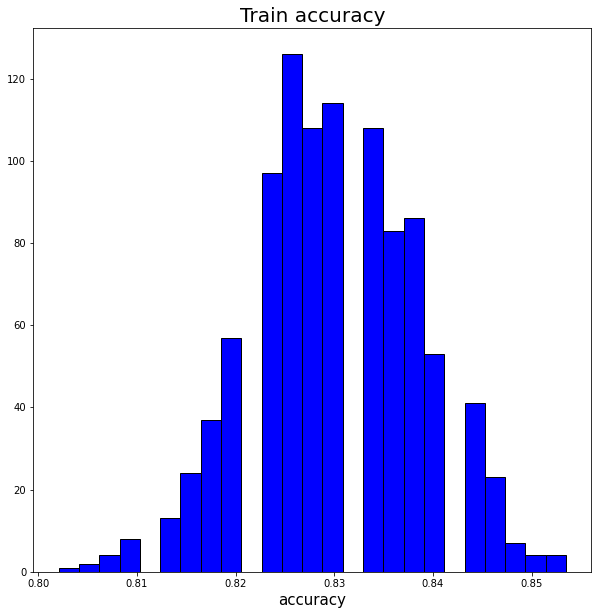

In [30]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [31]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.8297532133676093
0.008435216280116908


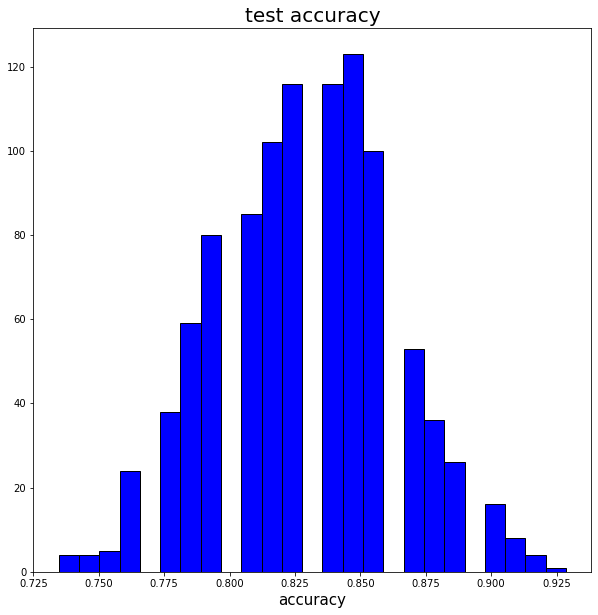

In [32]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [33]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.8290510204081633
0.03321579983382281


# Word2vec

## ingredients

In [123]:
df['meal_ingredients'] = df['meal_ingredients'].apply(lambda x: preprocess_meals(x))

In [124]:
meal_ingredients = df.meal_ingredients.apply(gensim.utils.simple_preprocess)

In [125]:
meal_ingredients

0                                              [pretzel]
1                                [turkey, burger, salad]
2                                    [quinoa, vegetable]
3                                       [chicken, salad]
4                                 [salad, sweet, potato]
                             ...                        
943    [chicken, patty, wholewheat, wrap, mozzarella,...
944    [bowl, oatmeal, hard, boiled, egg, oz, bottle,...
945                                            [oatmeal]
946    [whiting, fish, sandwich, tablespoon, tartar, ...
947    [bowl, minestrone, soup, slice, whole, wheat, ...
Name: meal_ingredients, Length: 944, dtype: object

In [126]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients, progress_per = 100)

embeddings.train(meal_ingredients, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients = embeddings.wv.index_to_key

In [127]:
learned_words_meal_ingredients

['oz',
 'water',
 'cheese',
 'chicken',
 'rice',
 'bottle',
 'cup',
 'tomato',
 'egg',
 'bread',
 'salad',
 'lettuce',
 'coffee',
 'onion',
 'black',
 'pepper',
 'potato',
 'banana',
 'one',
 'milk',
 'red',
 'sugar',
 'sauce',
 'corn',
 'beans',
 'green',
 'bean',
 'spinach',
 'wheat',
 'beef',
 'carrots',
 'white',
 'fat',
 'boiled',
 'broccoli',
 'sausage',
 'eggs',
 'mixed',
 'sandwich',
 'whole',
 'hard',
 'turkey',
 'yellow',
 'ham',
 'pork',
 'avocado',
 'butter',
 'slice',
 'soup',
 'cucumber',
 'oil',
 'dressing',
 'tspn',
 'tomatoes',
 'cream',
 'half',
 'carrot',
 'onions',
 'olive',
 'oatmeal',
 'ketchup',
 'vegetable',
 'sweet',
 'bacon',
 'strawberry',
 'raw',
 'fried',
 'breast',
 'steak',
 'splenda',
 'garlic',
 'roll',
 'hot',
 'mayo',
 'chocolate',
 'bbq',
 'cereal',
 'peppers',
 'cheddar',
 'potatoes',
 'salt',
 'meat',
 'orange',
 'mushroom',
 'peanut',
 'apple',
 'lightly',
 'juice',
 'vanilla',
 'roast',
 'spoon',
 'bun',
 'shrimp',
 'fish',
 'cherry',
 'cabbage',

In [128]:
words = []
for i in meal_ingredients:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [129]:
l = []
eg = 0
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [130]:
data_y = np.squeeze(data_y)
data_y.shape

(944,)

In [131]:
data_X = pd.DataFrame(l)
data_X.shape

(944, 100)

In [132]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

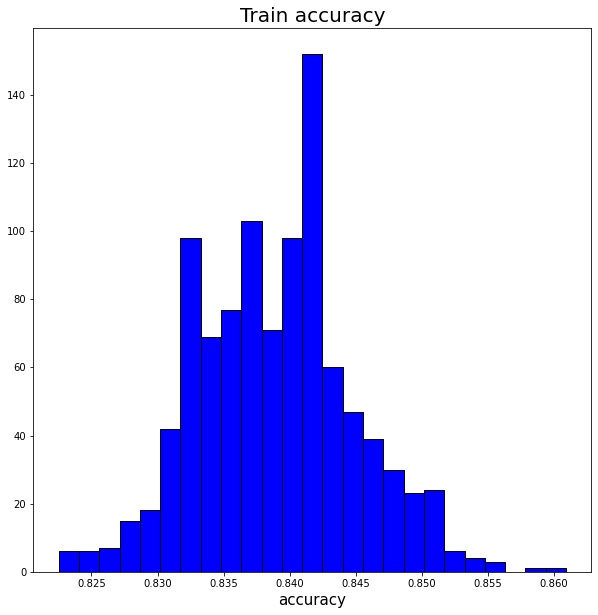

In [133]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [134]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.8389377483443708
0.005946650529099595


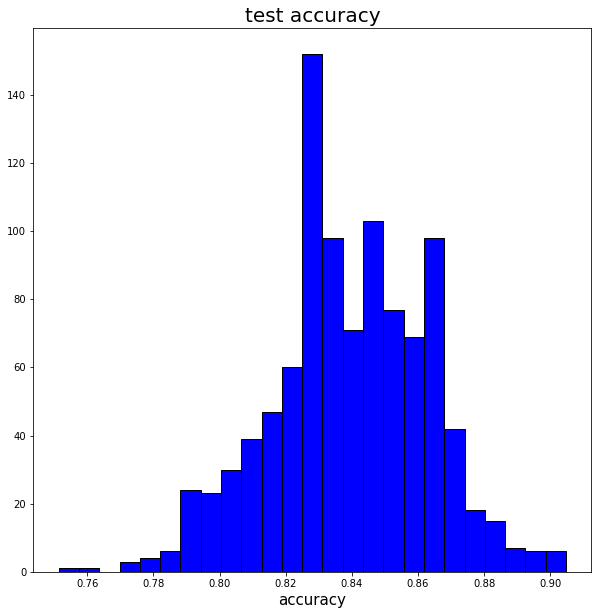

In [135]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [136]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.839164021164021
0.023755138356985176


## title

In [149]:
df['meal_title'].isnull().sum()

0

In [150]:
df['meal_title'] = df['meal_title'].astype(str)

In [151]:
df = df.dropna(axis=0, subset=['meal_title'])

In [152]:
df['meal_title'].isnull().sum()

0

In [153]:
meal_title = df.meal_title.apply(gensim.utils.simple_preprocess)

In [154]:
meal_title

0                                              [pretzel]
1                          [salad, with, turkey, burger]
2                              [quinoa, and, vegetables]
3                     [chicken, with, mixed, vegetables]
4                 [salad, sweet, potatoes, and, avocado]
                             ...                        
943          [chicken, parmesan, with, wholewheat, wrap]
944    [bowl, of, oatmeal, hard, boiled, eggs, and, b...
945                                             [cereal]
946    [whiting, fish, sandwich, and, bottle, of, water]
947    [minestrone, soup, whole, wheat, bread, and, w...
Name: meal_title, Length: 944, dtype: object

In [155]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_title, progress_per = 100)

embeddings.train(meal_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_title = embeddings.wv.index_to_key

In [156]:
learned_words_meal_title

['and',
 'of',
 'water',
 'salad',
 'with',
 'bottle',
 'chicken',
 'rice',
 'cheese',
 'eggs',
 'coffee',
 'beans',
 'sandwich',
 'bread',
 'banana',
 'cup',
 'soup',
 'boiled',
 'black',
 'egg',
 'mixed',
 'yellow',
 'hard',
 'oatmeal',
 'sausage',
 'breakfast',
 'oz',
 'beef',
 'cereal',
 'lunch',
 'tomato',
 'red',
 'vegetables',
 'steak',
 'dinner',
 'fruit',
 'onions',
 'broccoli',
 'fries',
 'lettuce',
 'carrots',
 'potato',
 'turkey',
 'on',
 'pork',
 'breast',
 'ribs',
 'yogurt',
 'meatballs',
 'roll',
 'potatoes',
 'wheat',
 'cream',
 'fish',
 'whole',
 'fried',
 'ham',
 'food',
 'bbq',
 'burger',
 'white',
 'roast',
 'sweet',
 'avocado',
 'pizza',
 'bacon',
 'shake',
 'noodles',
 'peppers',
 'bagel',
 'gandules',
 'crackers',
 'bowl',
 'baked',
 'toast',
 'tangerine',
 'spaghetti',
 'apple',
 'grits',
 'string',
 'veggies',
 'shrimp',
 'milk',
 'sugar',
 'smoothie',
 'pepper',
 'mix',
 'mac',
 'cabbage',
 'large',
 'half',
 'buttered',
 'juice',
 'chops',
 'corn',
 'bar',
 '

In [157]:
words = []
for i in meal_title:
    temp = []
    for j in i:
        if j in learned_words_meal_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [158]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [159]:
data_y = np.squeeze(data_y)
data_y.shape

(944,)

In [160]:
data_X = pd.DataFrame(l)
data_X.shape

(944, 100)

In [161]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

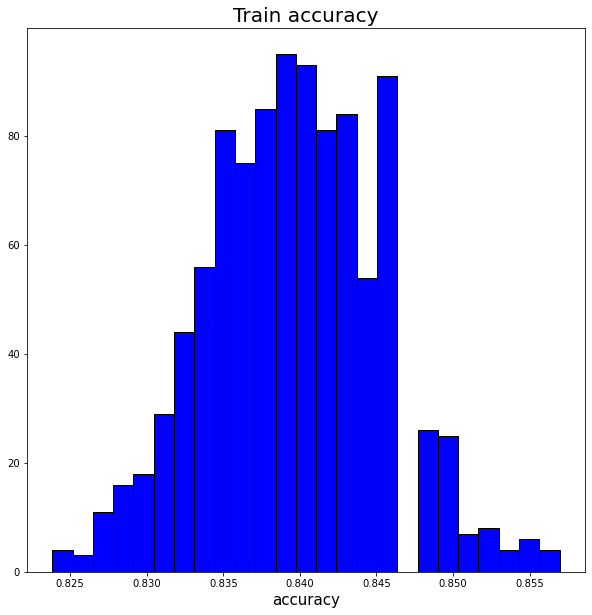

In [162]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [163]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.8389311258278145
0.005730149585421296


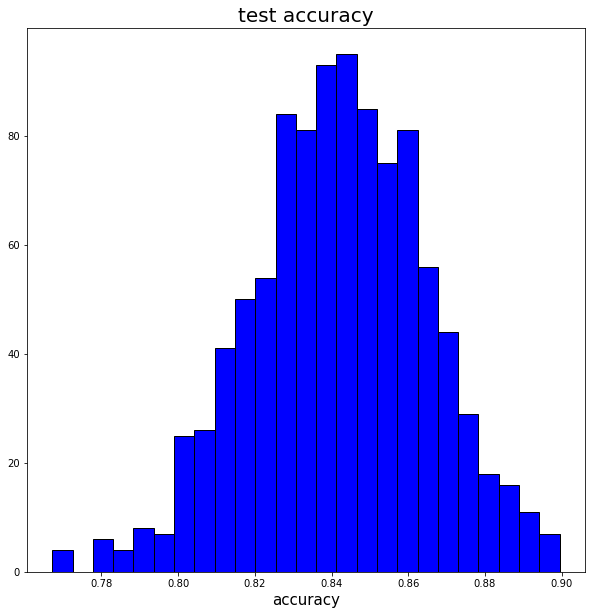

In [164]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [165]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.8391904761904762
0.02289028008991048


## ingredients_and_title

In [166]:
df['ingredients_and_title'] = df['meal_ingredients'].astype(str) +' '+ df['meal_title'].astype(str)

In [167]:
df['ingredients_and_title']

0                                        Pretzel Pretzel
1           Turkey burger salad Salad with turkey burger
2                 Quinoa vegetable Quinoa and vegetables
3            Chicken salad Chicken with mixed vegetables
4      Salad sweet potato Salad ,sweet potatoes and a...
                             ...                        
943    Chicken patty, wholewheat wrap ,mozzarella che...
944    Bowl oatmeal, 2 x hard-boiled egg 16 oz bottle...
945                                       Oatmeal Cereal
946    Whiting fish sandwich 1 x tablespoon tartar ho...
947    Bowl Minestrone soup, 2 x slice whole wheat br...
Name: ingredients_and_title, Length: 944, dtype: object

In [168]:
meal_ingredients_title = df.ingredients_and_title.apply(gensim.utils.simple_preprocess)

In [169]:
meal_ingredients_title

0                                     [pretzel, pretzel]
1      [turkey, burger, salad, salad, with, turkey, b...
2           [quinoa, vegetable, quinoa, and, vegetables]
3      [chicken, salad, chicken, with, mixed, vegetab...
4      [salad, sweet, potato, salad, sweet, potatoes,...
                             ...                        
943    [chicken, patty, wholewheat, wrap, mozzarella,...
944    [bowl, oatmeal, hard, boiled, egg, oz, bottle,...
945                                    [oatmeal, cereal]
946    [whiting, fish, sandwich, tablespoon, tartar, ...
947    [bowl, minestrone, soup, slice, whole, wheat, ...
Name: ingredients_and_title, Length: 944, dtype: object

In [170]:
embeddings = gensim.models.Word2Vec(
        window = 1,
        min_count = 1,
        workers = 1)

embeddings.build_vocab(meal_ingredients_title, progress_per = 100)

embeddings.train(meal_ingredients_title, total_examples = embeddings.corpus_count, epochs = 5)
learned_words_meal_ingredients_title = embeddings.wv.index_to_key

In [171]:
learned_words_meal_ingredients_title

['and',
 'water',
 'chicken',
 'cheese',
 'bottle',
 'rice',
 'salad',
 'oz',
 'of',
 'coffee',
 'cup',
 'bread',
 'tomato',
 'egg',
 'with',
 'eggs',
 'beans',
 'lettuce',
 'banana',
 'black',
 'sandwich',
 'potato',
 'red',
 'boiled',
 'mixed',
 'pepper',
 'soup',
 'onion',
 'yellow',
 'sausage',
 'beef',
 'milk',
 'hard',
 'one',
 'sugar',
 'sauce',
 'wheat',
 'carrots',
 'broccoli',
 'corn',
 'spinach',
 'white',
 'green',
 'turkey',
 'pork',
 'oatmeal',
 'bean',
 'whole',
 'ham',
 'fat',
 'onions',
 'avocado',
 'cream',
 'steak',
 'cereal',
 'butter',
 'breast',
 'half',
 'slice',
 'roll',
 'fried',
 'sweet',
 'tomatoes',
 'dressing',
 'bacon',
 'tspn',
 'fruit',
 'cucumber',
 'oil',
 'potatoes',
 'carrot',
 'vegetable',
 'yogurt',
 'bbq',
 'fish',
 'vegetables',
 'peppers',
 'olive',
 'fries',
 'apple',
 'roast',
 'ribs',
 'ketchup',
 'breakfast',
 'hot',
 'garlic',
 'juice',
 'bowl',
 'shrimp',
 'orange',
 'peanut',
 'cheddar',
 'raw',
 'lunch',
 'meat',
 'strawberry',
 'meatbal

In [172]:
words = []
for i in meal_ingredients_title:
    temp = []
    for j in i:
        if j in learned_words_meal_ingredients_title:
            temp.append(j)
        else:
            print(i)
    words.append(temp)

In [173]:
l = []
for i in range(len(words)):
        if len(words[i])>=1:
            a = np.mean(embeddings.wv[words[i]], axis=0)
            l.append(a)
        else:
            l.append(np.asarray(100 * [0]))

In [174]:
data_y = np.squeeze(data_y)
data_y.shape

(944,)

In [175]:
data_X = pd.DataFrame(l)
data_X.shape

(944, 100)

In [176]:
train_accuracy = []
test_accuracy = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, shuffle = True)
#     tfidf = TfidfVectorizer(max_features=100, lowercase=True, analyzer='word',
#                         stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
#     train = tfidf.fit_transform(X_train)
#     test = tfidf.transform(X_test)
    lr = LogisticRegression()
    #scores = cross_val_score(lr, train, y_train, cv=3)
    y_pred_train = cross_val_predict(lr, X_train, y_train, cv=3)
    #y_pred_test = cross_val_predict(lr, test, y_test, cv=3)
    lr.fit(X_train, y_train)
    #y_pred_train = lr.predict(train)
    y_pred_test = lr.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

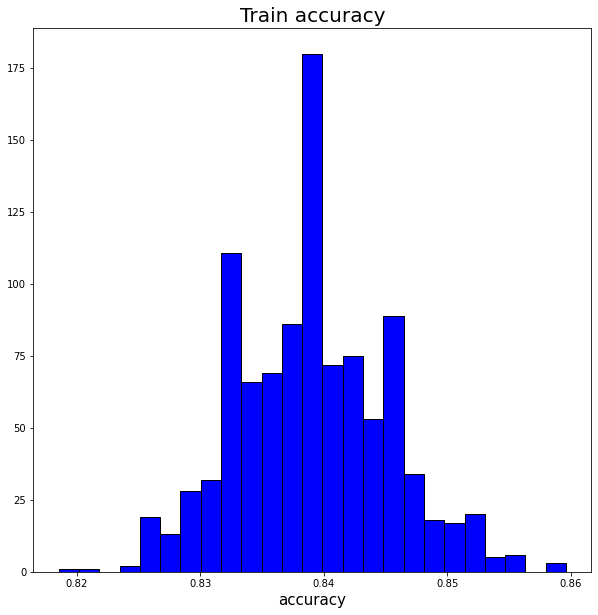

In [177]:
plt.figure(figsize=(10,10))  
plt.hist(train_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('Train accuracy', size = 20)
plt.xlabel('accuracy', size = 15)

plt.show()

In [178]:
print(np.mean(train_accuracy))
print(np.std(train_accuracy))

0.8389867549668875
0.006215827150970181


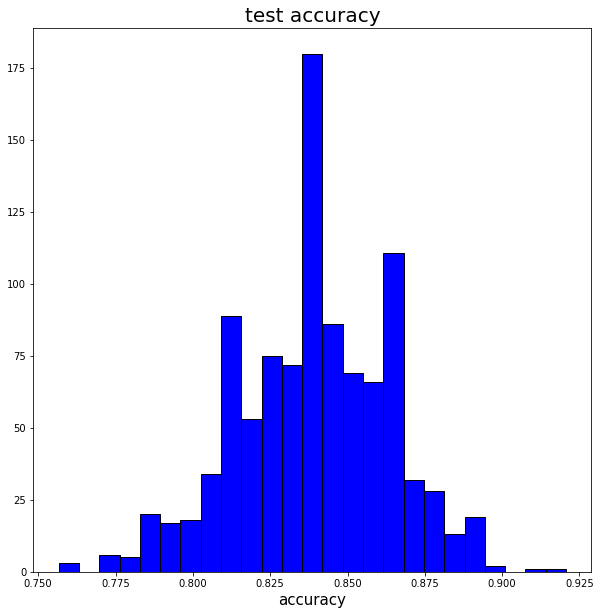

In [179]:
plt.figure(figsize=(10,10))  
plt.hist(test_accuracy, bins = 25,
             color = 'blue', edgecolor = 'black')
plt.title('test accuracy', size = 20)
plt.xlabel('accuracy', size = 15)
#plt.ylabel('Flights', size= 22)

#plt.tight_layout()
plt.show()

In [180]:
print(np.mean(test_accuracy))
print(np.std(test_accuracy))

0.838968253968254
0.02483042062953698
